### Siapakaan Model 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_12000.csv')
df.head(10)

,content,sentimen
0,trotoar jalan margonda raya depok jawa barat j...,negatif
1,ratusan jemaat mengikuti misa malam natal gere...,negatif
2,tentara lebanon tewas akibat serangan israel p...,negatif
3,serangan besaran hamas israel mendadak pekan m...,negatif
4,insiden mengerikan acara konser musik salah un...,negatif
5,calon presiden nomor urut 3 ganjar pranowo men...,negatif
6,uskup agung jakarta ignatius kardinal suharyo ...,negatif
7,rianto 44 pedagang tempe pasar kota bekasi men...,negatif
8,jalan imam bonjol kantor komisi pemilihan umum...,negatif
9,calon presiden koalisi perubahan persatuan kpp...,negatif


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

#### World Cloud

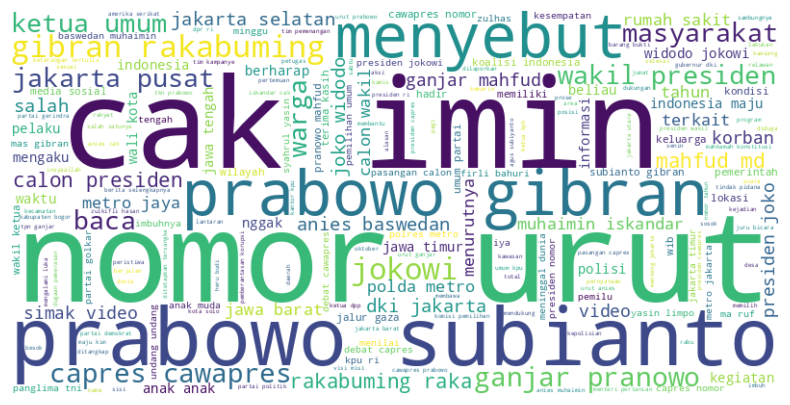

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### LSA

LSA Topics:

Topic #0:
prabowo gibran ganjar cawapres presiden debat mahfud anies jokowi partai

Topic #1:
kpk israel firli gaza korban syl hamas tersangka metro palestina

Topic #2:
israel gaza hamas palestina serangan jalur gaza jalur perang tewas warga

Topic #3:
ganjar anies debat mahfud imin cak cak imin kpu muhaimin ganjar mahfud

Topic #4:
israel kpk firli gaza hamas debat syl serangan palestina gibran

Topic #5:
ganjar mahfud jokowi ganjar mahfud pranowo ganjar pranowo presiden pdip md mahfud md

Topic #6:
anies imin cak cak imin jokowi tni presiden amin agus muhaimin

Topic #7:
debat tni jokowi agus panglima panglima tni jenderal ksad kpu subiyanto

Topic #8:
mk konstitusi mkmk putusan hakim mahkamah mahkamah konstitusi anwar usia anwar usman

Topic #9:
tni agus gibran panglima panglima tni jenderal ksad subiyanto agus subiyanto jenderal agus


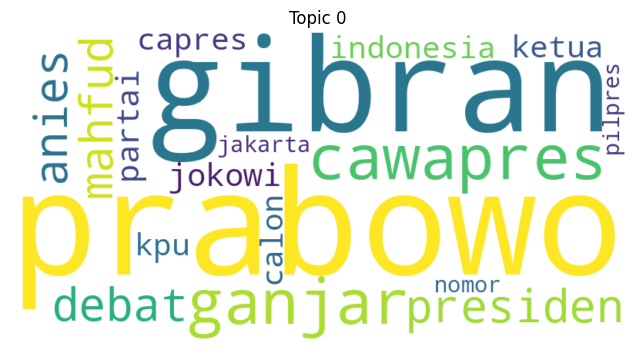

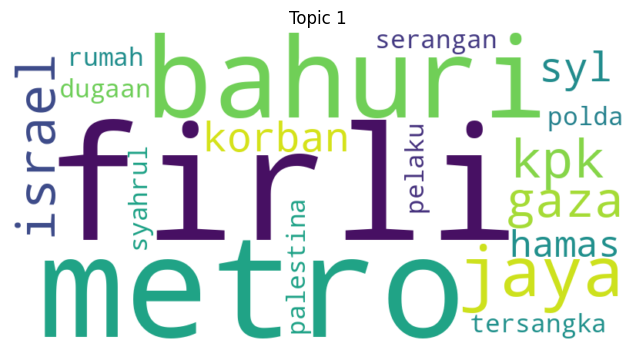

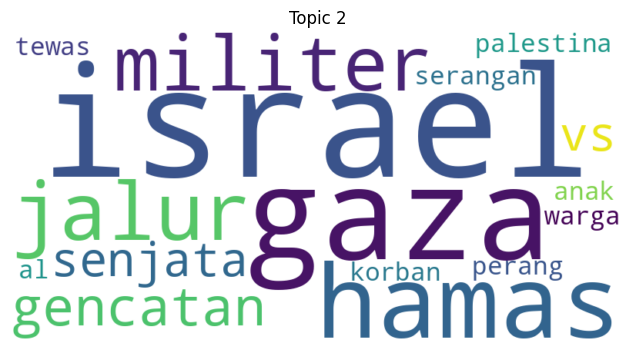

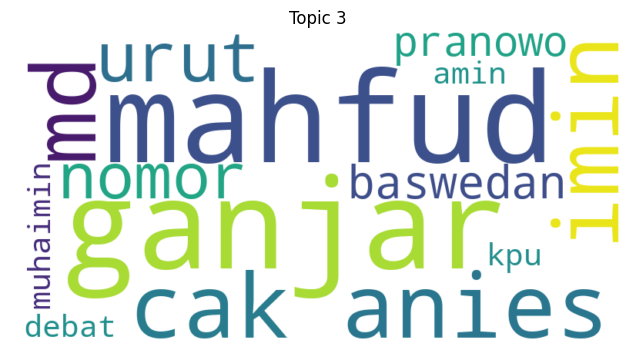

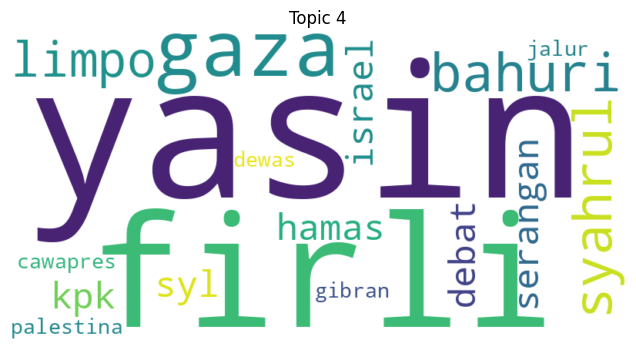

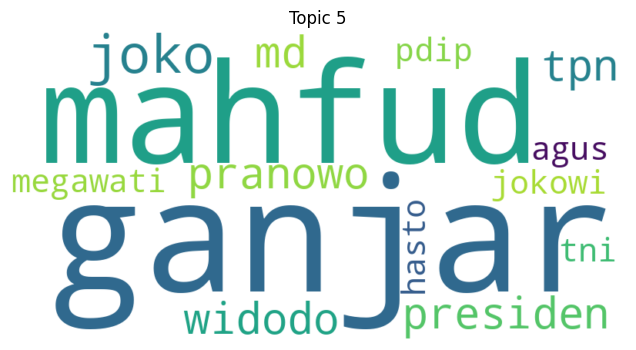

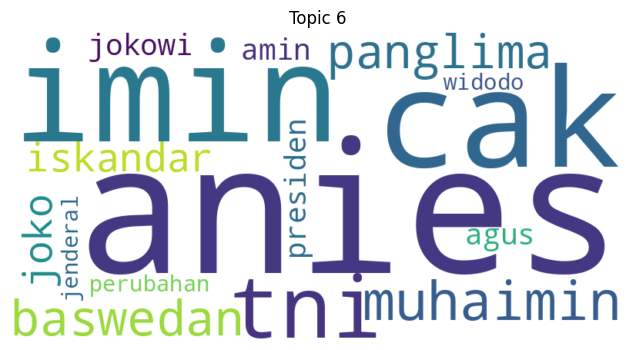

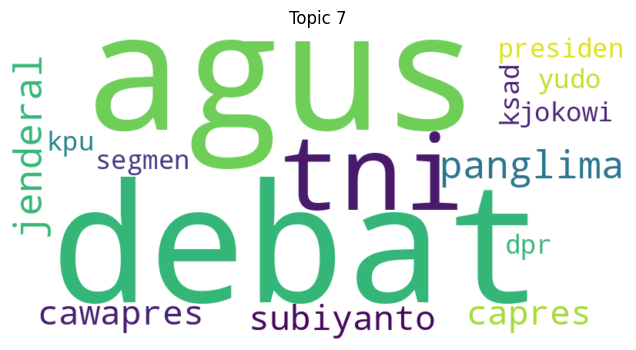

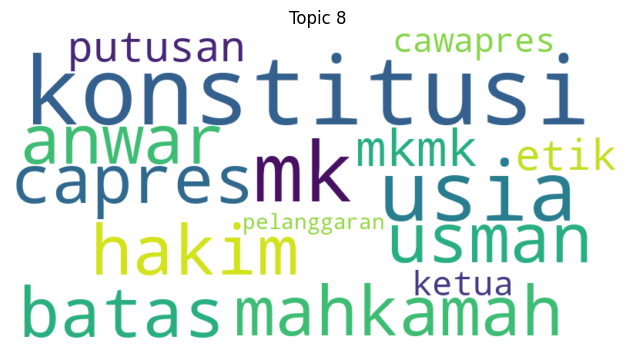

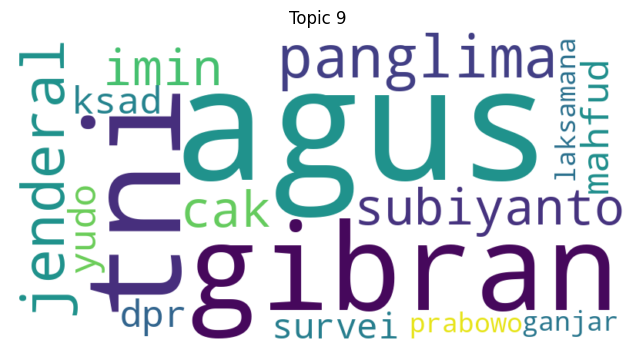

In [10]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Define the number of topics
num_topics = 10

# Perform LSA
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_train_features = lsa_model.fit_transform(tfidf_train_features)

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to print the most important words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Print the most important words for each topic
print("LSA Topics:")
print_top_words(lsa_model, feature_names, 10)

# Generate a word cloud for each topic
for i in range(num_topics):
    # Get the most important words for the topic
    top_words = [feature_names[j] for j in lsa_model.components_[i].argsort()[:-20 - 1:-1]]
    # Join them into a single string
    topic_text = ' '.join(top_words)
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)
    # Display the generated image
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Topic ' + str(i))
    plt.axis('off')
    plt.show()


### Naiye Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [12]:
# Train Naive Bayes classifier
nb_classifier = MultinomialNB(alpha= 0.1,fit_prior=False)
nb_classifier.fit(tfidf_train_features, y_train_encoded)

# Predict on test data
y_pred = nb_classifier.predict(tfidf_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred) * 100
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test_encoded, y_pred, average='weighted') * 100
print("F1 Score:", f1)

Accuracy: 70.77777777777777
F1 Score: 70.29280678915542


#### Model SVM

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Initialize SVM model
svm_model = SVC(C=100, gamma=0.1, kernel='sigmoid', random_state=42)

# Fit the model
svm_model.fit(tfidf_train_features, y_train_encoded)

# Predict on test data
y_pred = svm_model.predict(tfidf_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.7741666666666667
F1 Score: 0.7733687904660757
